## Análise da Produção de Cupuaçu no Amazonas: Evidências e Visualizações de 2023 por Johann Kotaro e Cassius Clay

### Importando Bibliotecas necessárias

In [27]:
# Bibliotecas necessárias para análise espacial
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import time
from sklearn.cluster import KMeans
import seaborn as sns


### Importando dados após tratamento

In [2]:
# Carregar o arquivo Excel com os dados de produção de cupuaçu com coordenadas
df = pd.read_excel("producao_cupuaçu_com_coordenadas.xlsx")
df.head()  # Visualizar as primeiras linhas do DataFrame


,Unidade local,Nº de Beneficiários,Plantada (ha),Colhida (ha),Produção (mil frutos),Nº de Beneficiários (est.),Plantada (ha) (est.),Em produção (ha) (est.),Produção (mil frutos) (est.),Latitude,Longitude
0,Amaturá,3,2.28,0.98,1.96,80,12.00,4.75,7.60,-3.364051,-68.199469
1,Atalaia do Norte,1,0.10,0.10,0.10,70,35.00,35.00,28.00,-4.365855,-70.190874
2,Benjamin Constant,3,3.50,3.40,8.50,40,28.00,27.00,54.00,-4.378275,-70.029060
3,São Paulo de Olivença,9,1.85,1.85,3.70,12,12.00,12.00,19.20,-3.465063,-68.946846
4,Tabatinga,39,9.38,9.38,9.38,39,9.38,9.38,9.38,-4.232735,-69.926337


In [3]:
# Verificar as coordenadas
df[['Unidade local', 'Latitude', 'Longitude']].head()


,Unidade local,Latitude,Longitude
0,Amaturá,-3.364051,-68.199469
1,Atalaia do Norte,-4.365855,-70.190874
2,Benjamin Constant,-4.378275,-70.029060
3,São Paulo de Olivença,-3.465063,-68.946846
4,Tabatinga,-4.232735,-69.926337


### Criação e tratamento de um GeoDataFrame

In [4]:
# Converter para GeoDataFrame com base nas coordenadas (Longitude, Latitude) (Um object GeoDataFrame é um pandas.DataFrame que possui uma ou mais colunas contendo geometria.)
geometry = [Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Definir o sistema de referência de coordenadas (CRS)
gdf.set_crs('EPSG:4326', inplace=True)  # CRS padrão WGS 84 (Latitude/Longitude)
gdf.head()


,Unidade local,Nº de Beneficiários,Plantada (ha),Colhida (ha),Produção (mil frutos),Nº de Beneficiários (est.),Plantada (ha) (est.),Em produção (ha) (est.),Produção (mil frutos) (est.),Latitude,Longitude,geometry
0,Amaturá,3,2.28,0.98,1.96,80,12.00,4.75,7.60,-3.364051,-68.199469,POINT (-68.19947 -3.36405)
1,Atalaia do Norte,1,0.10,0.10,0.10,70,35.00,35.00,28.00,-4.365855,-70.190874,POINT (-70.19087 -4.36585)
2,Benjamin Constant,3,3.50,3.40,8.50,40,28.00,27.00,54.00,-4.378275,-70.029060,POINT (-70.02906 -4.37827)
3,São Paulo de Olivença,9,1.85,1.85,3.70,12,12.00,12.00,19.20,-3.465063,-68.946846,POINT (-68.94685 -3.46506)
4,Tabatinga,39,9.38,9.38,9.38,39,9.38,9.38,9.38,-4.232735,-69.926337,POINT (-69.92634 -4.23273)


In [5]:
# Remover as linhas onde Latitude ou Longitude são NaN (Vazias)
gdf_clean = gdf.dropna(subset=['Latitude', 'Longitude'])

# Verificar se as linhas foram removidas
gdf_clean.head()


,Unidade local,Nº de Beneficiários,Plantada (ha),Colhida (ha),Produção (mil frutos),Nº de Beneficiários (est.),Plantada (ha) (est.),Em produção (ha) (est.),Produção (mil frutos) (est.),Latitude,Longitude,geometry
0,Amaturá,3,2.28,0.98,1.96,80,12.00,4.75,7.60,-3.364051,-68.199469,POINT (-68.19947 -3.36405)
1,Atalaia do Norte,1,0.10,0.10,0.10,70,35.00,35.00,28.00,-4.365855,-70.190874,POINT (-70.19087 -4.36585)
2,Benjamin Constant,3,3.50,3.40,8.50,40,28.00,27.00,54.00,-4.378275,-70.029060,POINT (-70.02906 -4.37827)
3,São Paulo de Olivença,9,1.85,1.85,3.70,12,12.00,12.00,19.20,-3.465063,-68.946846,POINT (-68.94685 -3.46506)
4,Tabatinga,39,9.38,9.38,9.38,39,9.38,9.38,9.38,-4.232735,-69.926337,POINT (-69.92634 -4.23273)


In [6]:
# Criar um GeoDataFrame com as coordenadas de latitude e longitude
gdf_clean = gpd.GeoDataFrame(gdf_clean, 
                             geometry=gpd.points_from_xy(gdf_clean['Longitude'], gdf_clean['Latitude']))

# Definir o CRS (Sistema de Referência de Coordenadas) adequado para o Amazonas (pode ser EPSG:4326) e Visualizar o GeoDataFrame Limpo inteiro 
gdf_clean.set_crs('EPSG:4326', inplace=True)

,Unidade local,Nº de Beneficiários,Plantada (ha),Colhida (ha),Produção (mil frutos),Nº de Beneficiários (est.),Plantada (ha) (est.),Em produção (ha) (est.),Produção (mil frutos) (est.),Latitude,Longitude,geometry
0,Amaturá,3,2.28,0.98,1.96,80,12.00,4.75,7.60,-3.364051,-68.199469,POINT (-68.19947 -3.36405)
1,Atalaia do Norte,1,0.10,0.10,0.10,70,35.00,35.00,28.00,-4.365855,-70.190874,POINT (-70.19087 -4.36585)
2,Benjamin Constant,3,3.50,3.40,8.50,40,28.00,27.00,54.00,-4.378275,-70.029060,POINT (-70.02906 -4.37827)
3,São Paulo de Olivença,9,1.85,1.85,3.70,12,12.00,12.00,19.20,-3.465063,-68.946846,POINT (-68.94685 -3.46506)
4,Tabatinga,39,9.38,9.38,9.38,39,9.38,9.38,9.38,-4.232735,-69.926337,POINT (-69.92634 -4.23273)
5,Alvarães,7,3.00,3.00,4.50,10,4.00,4.00,4.80,-3.215579,-64.814833,POINT (-64.81483 -3.21558)
6,Fonte Boa,7,1.30,1.30,2.60,8,1.50,1.50,2.60,-2.514746,-66.094842,POINT (-66.09484 -2.51475)
7,Japurá,9,2.60,0.60,0.60,28,9.60,7.60,6.08,-1.880847,-66.996766,POINT (-66.99677 -1.88085)
8,Juruá,31,5.94,5.94,11.88,32,8.00,8.00,12.80,-3.474667,-66.062234,POINT (-66.06223 -3.47467)
9,Jutaí,5,4.70,3.70,11.10,80,45.00,44.00,105.60,-2.747148,-66.772126,POINT (-66.77213 -2.74715)


### Mapa com todas Unidades Locais usando Folium

In [7]:
# Criar o mapa interativo com as localizações limpas
m = folium.Map(location=[gdf_clean['Latitude'].mean(), gdf_clean['Longitude'].mean()], zoom_start=6)

# Adicionar os pontos ao mapa com um popup para cada unidade local
for _, row in gdf_clean.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Unidade local']).add_to(m)

# Exibir o mapa
m


### Mapa de calor geográfico para visualizar a densidade da produção de cupuaçu

In [8]:
from folium.plugins import HeatMap

# Criar um mapa base
m = folium.Map(location=[gdf_clean['Latitude'].mean(), gdf_clean['Longitude'].mean()], zoom_start=6)

# Adicionar uma camada de calor para visualizar a densidade de produção
heat_data = [[row['Latitude'], row['Longitude'], row['Produção (mil frutos)']] for _, row in gdf_clean.iterrows()]
HeatMap(heat_data).add_to(m)

# Exibir o mapa
m


### Criação do Modelo de Clusterização

In [9]:
# Definir o número de clusters
kmeans = KMeans(n_clusters=4, random_state=42) # A quantidade de Clusters é definida arbitráriamente, ou seja, sem uso de otimização de quantidade de Clusters

# Aplicar o KMeans nas coordenadas (Latitude e Longitude)
coords = gdf_clean[['Latitude', 'Longitude']].values
gdf_clean['Cluster'] = kmeans.fit_predict(coords)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [25]:
# Criar o mapa base
m = folium.Map(location=[gdf_clean['Latitude'].mean(), gdf_clean['Longitude'].mean()], zoom_start=6)

# Adicionar os pontos ao mapa, colorindo-os de acordo com o "cluster"
for _, row in gdf_clean.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']], 
                        radius=5, 
                        color=f"#{hex(row['Cluster']*555555)[2:8]}",  # Cor diferente para cada "cluster"
                        fill=True, 
                        fill_color=f"#{hex(row['Cluster']*555555)[2:8]}").add_to(m)

# Exibir o mapa
m


In [11]:
# Obter as coordenadas dos centros de cada cluster, os centróides
cluster_centers = kmeans.cluster_centers_

# Adicionar os centros no mapa
for center in cluster_centers:
    folium.Marker([center[0], center[1]], 
                  popup="Centro do Cluster", 
                  icon=folium.Icon(color='red')).add_to(m)

# Exibir o mapa com os centros dos clusters
m


In [12]:
# Contar a quantidade de Unidade Locais por cluster
cluster_counts = gdf_clean['Cluster'].value_counts()
print("Quantidade de Unidade Local pór Cluster")
print(cluster_counts)


Quantidade de Unidade Local pór Cluster
Cluster
0    22
3    11
2    10
1     8
Name: count, dtype: int64


In [13]:
# Exibir o GeoDataFrame completo
gdf_clean

,Unidade local,Nº de Beneficiários,Plantada (ha),Colhida (ha),Produção (mil frutos),Nº de Beneficiários (est.),Plantada (ha) (est.),Em produção (ha) (est.),Produção (mil frutos) (est.),Latitude,Longitude,geometry,Cluster
0,Amaturá,3,2.28,0.98,1.96,80,12.00,4.75,7.60,-3.364051,-68.199469,POINT (-68.19947 -3.36405),2
1,Atalaia do Norte,1,0.10,0.10,0.10,70,35.00,35.00,28.00,-4.365855,-70.190874,POINT (-70.19087 -4.36585),1
2,Benjamin Constant,3,3.50,3.40,8.50,40,28.00,27.00,54.00,-4.378275,-70.029060,POINT (-70.02906 -4.37827),1
3,São Paulo de Olivença,9,1.85,1.85,3.70,12,12.00,12.00,19.20,-3.465063,-68.946846,POINT (-68.94685 -3.46506),1
4,Tabatinga,39,9.38,9.38,9.38,39,9.38,9.38,9.38,-4.232735,-69.926337,POINT (-69.92634 -4.23273),1
5,Alvarães,7,3.00,3.00,4.50,10,4.00,4.00,4.80,-3.215579,-64.814833,POINT (-64.81483 -3.21558),2
6,Fonte Boa,7,1.30,1.30,2.60,8,1.50,1.50,2.60,-2.514746,-66.094842,POINT (-66.09484 -2.51475),2
7,Japurá,9,2.60,0.60,0.60,28,9.60,7.60,6.08,-1.880847,-66.996766,POINT (-66.99677 -1.88085),2
8,Juruá,31,5.94,5.94,11.88,32,8.00,8.00,12.80,-3.474667,-66.062234,POINT (-66.06223 -3.47467),2
9,Jutaí,5,4.70,3.70,11.10,80,45.00,44.00,105.60,-2.747148,-66.772126,POINT (-66.77213 -2.74715),2


In [14]:
#gdf_clean.to_excel("resultado_kmeans_clusterizacao.xlsx", index=False)


## Análise Descritiva por Cluster

In [15]:
# Análise descritiva dos clusters
df_clusters = gdf_clean.groupby('Cluster').agg({
    'Latitude': ['mean', 'min', 'max'],
    'Longitude': ['mean', 'min', 'max'],
    'Plantada (ha)': 'mean',
    'Colhida (ha)': 'mean',
    'Produção (mil frutos)': 'mean',
    'Nº de Beneficiários': 'mean'
}).reset_index()

# Exibindo a análise descritiva
df_clusters


Cluster  Latitude                      Longitude                        \
               mean       min       max       mean        min        max   
0       0 -3.044221 -4.393478 -0.798652 -59.211518 -61.209640 -56.731932   
1       1 -5.503173 -7.437889 -3.465063 -69.865299 -71.691232 -68.243739   
2       2 -2.205739 -3.474667 -0.122865 -65.868841 -68.199469 -62.925635   
3       3 -5.766117 -7.926952 -3.743525 -62.396782 -64.792451 -59.883019   

  Plantada (ha) Colhida (ha) Produção (mil frutos) Nº de Beneficiários  
           mean         mean                  mean                mean  
0     28.660000    25.987273             56.625455           33.863636  
1      5.005000     4.992500             10.281250           10.125000  
2      8.410000     5.096000             11.755000           23.000000  
3      5.264545     4.387273              9.015455            8.272727

## Distribuição da Produção por Cluster

In [16]:
# Total de produção por cluster
total_producao_por_cluster = gdf_clean.groupby('Cluster')['Produção (mil frutos)'].sum()

# Porcentagem da produção total por cluster
percentual_producao = (total_producao_por_cluster / total_producao_por_cluster.sum()) * 100

# Exibindo os resultados
resultados_producao = pd.DataFrame({
    'Total de Produção (mil frutos)': total_producao_por_cluster,
    'Percentual da Produção (%)': percentual_producao
}).sort_values(by='Total de Produção (mil frutos)', ascending=False)

resultados_producao


,Total de Produção (mil frutos),Percentual da Produção (%)
Cluster,,
0,1245.76,80.645809
2,117.55,7.609744
3,99.17,6.419892
1,82.25,5.324555


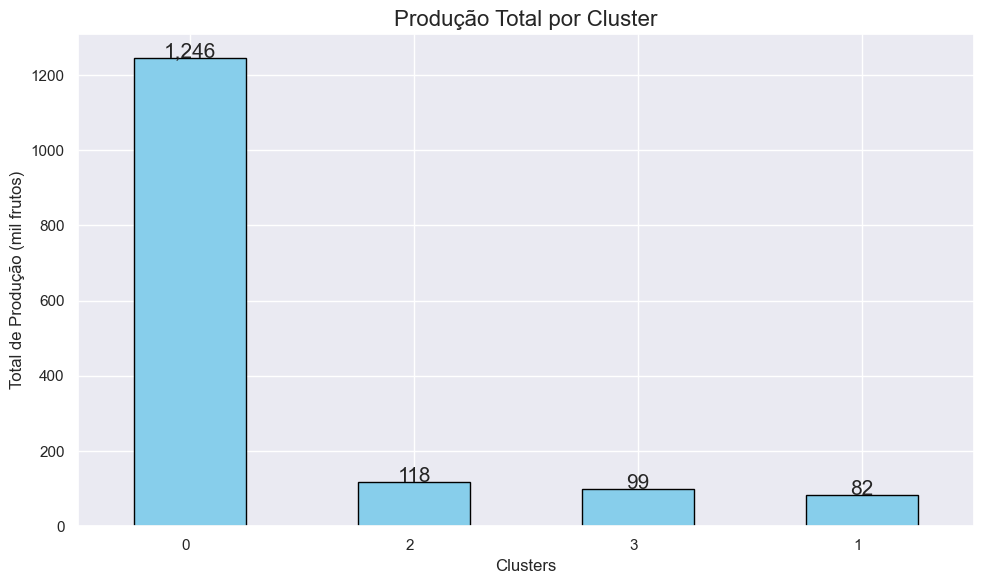

In [86]:
sns.set_theme(style="darkgrid")

# Criar o gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
resultados_producao['Total de Produção (mil frutos)'].plot(
    kind='bar',
    ax=ax,
    color='skyblue',
    edgecolor='black')

# Adicionar título e rótulos
ax.set_title('Produção Total por Cluster', fontsize=16)
ax.set_xlabel('Clusters', fontsize=12)
ax.set_ylabel('Total de Produção (mil frutos)', fontsize=12)
ax.set_xticklabels(resultados_producao.index, rotation=0, ha='right')

# Adicionar valores acima das barras
for i, v in enumerate(resultados_producao['Total de Produção (mil frutos)']):
    ax.text(i, v + 1.0, f"{v:,.0f}", ha='center', fontsize=15)

plt.tight_layout()
plt.show()


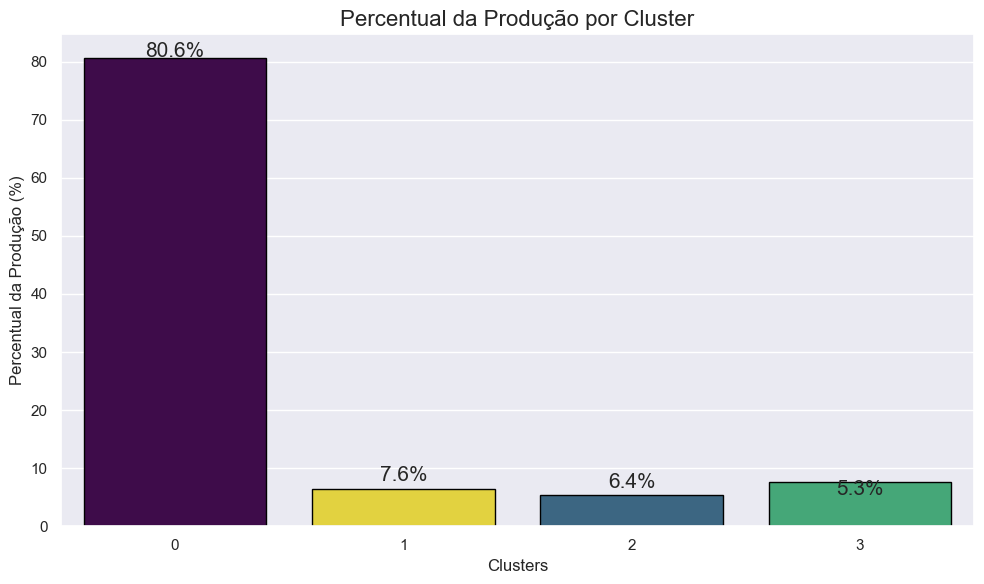

In [92]:
# Gráfico de barras para Percentual da Produção por Cluster
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    x=resultados_producao.index, 
    y=resultados_producao['Percentual da Produção (%)'], 
    data=df_areas_comparativas, 
    palette='viridis', 
    hue='Cluster',
    edgecolor='black',
    legend=False 
)

# Adicionar título e rótulos
ax.set_title('Percentual da Produção por Cluster', fontsize=16)
ax.set_xlabel('Clusters', fontsize=12)
ax.set_ylabel('Percentual da Produção (%)', fontsize=12)

# Adicionar valores nas barras
for i, v in enumerate(resultados_producao['Percentual da Produção (%)']):
    ax.text(i, v + 0.1, f"{v:.1f}%", ha='center', fontsize=15)

plt.tight_layout()
plt.show()


## Análise de Comparação das Áreas Plantadas e Colhidas

In [17]:
# Comparando as áreas plantadas e colhidas por cluster
df_areas_comparativas = gdf_clean.groupby('Cluster').agg({
    'Plantada (ha)': 'sum',
    'Colhida (ha)': 'sum'
}).reset_index()

# Exibindo as comparações
df_areas_comparativas['Taxa de Colheita (%)'] = (df_areas_comparativas['Colhida (ha)'] / df_areas_comparativas['Plantada (ha)']) * 100

df_areas_comparativas


,Cluster,Plantada (ha),Colhida (ha),Taxa de Colheita (%)
0,0,630.52,571.72,90.674364
1,1,40.04,39.94,99.750250
2,2,84.10,50.96,60.594530
3,3,57.91,48.26,83.336211


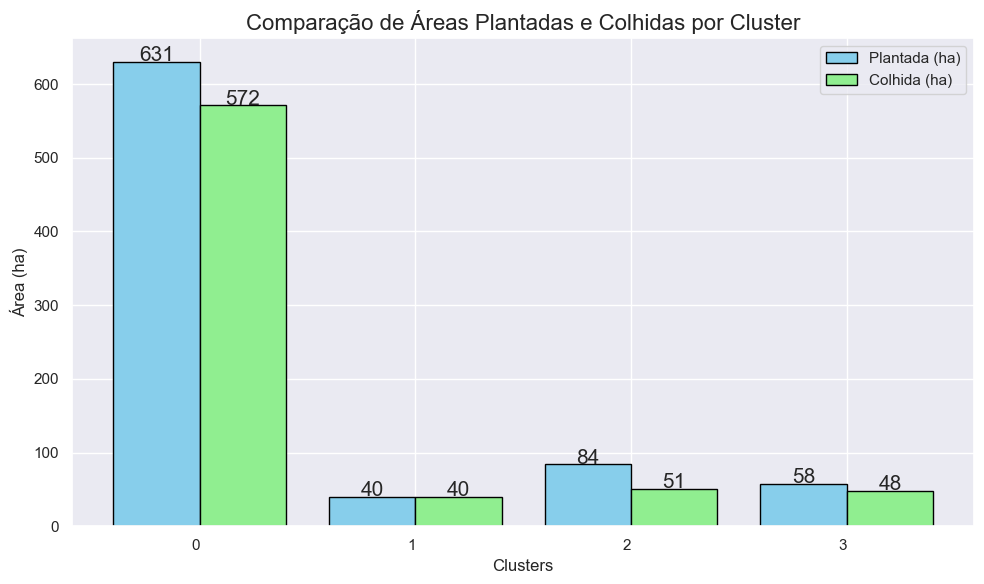

In [63]:
# Gráfico de barras para Plantada (ha) vs. Colhida (ha)
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
x = range(len(df_areas_comparativas['Cluster']))

# Barras de Plantada (ha)
ax.bar(x, df_areas_comparativas['Plantada (ha)'], width=bar_width, label='Plantada (ha)', color='skyblue', edgecolor='black')

# Barras de Colhida (ha)
ax.bar([i + bar_width for i in x], df_areas_comparativas['Colhida (ha)'], width=bar_width, label='Colhida (ha)', color='lightgreen', edgecolor='black')

# Adicionar rótulos e título
ax.set_title('Comparação de Áreas Plantadas e Colhidas por Cluster', fontsize=16)
ax.set_xlabel('Clusters', fontsize=12)
ax.set_ylabel('Área (ha)', fontsize=12)
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(df_areas_comparativas['Cluster'], rotation=0, ha='right')
ax.legend()

# Adicionar valores acima das barras
for i, v in enumerate(df_areas_comparativas['Plantada (ha)']):
    ax.text(i, v + 0.5, f"{v:,.0f}", ha='center', fontsize=15)
for i, v in enumerate(df_areas_comparativas['Colhida (ha)']):
    ax.text(i + bar_width, v + 0.5, f"{v:,.0f}", ha='center', fontsize=15)

plt.tight_layout()
plt.show()


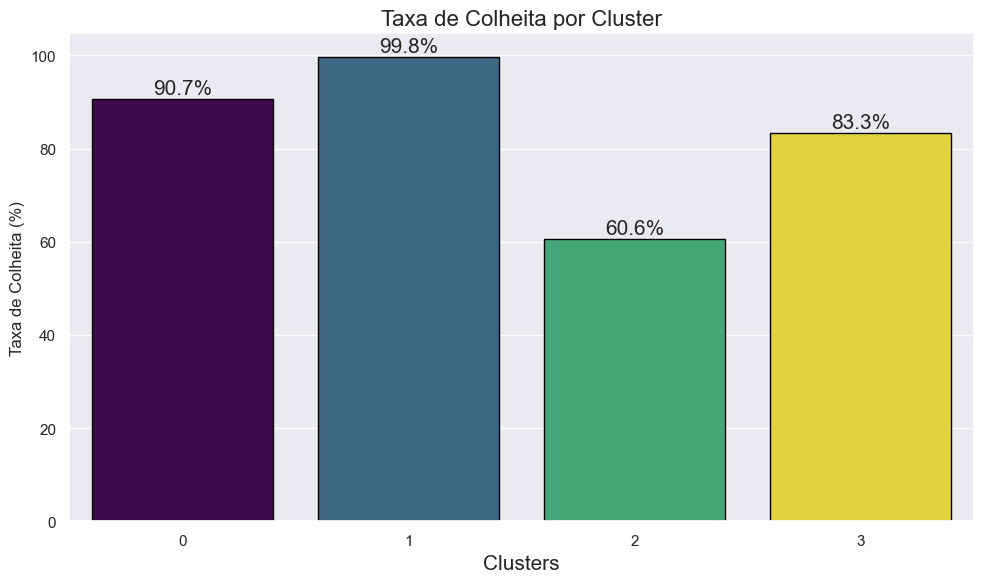

In [91]:
# Gráfico de barras verticais para a Taxa de Colheita (%)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    x='Cluster', 
    y='Taxa de Colheita (%)', 
    data=df_areas_comparativas, 
    palette='viridis', 
    hue='Cluster',
    edgecolor='black',
    legend=False 
)

# Adicionar título e rótulos
ax.set_title('Taxa de Colheita por Cluster', fontsize=16)
ax.set_xlabel('Clusters', fontsize=15)
ax.set_ylabel('Taxa de Colheita (%)', fontsize=12)

# Adicionar valores nas barras
for i, v in enumerate(df_areas_comparativas['Taxa de Colheita (%)']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=15)

plt.tight_layout()
plt.show()


## Análise de Eficiência (Produção por Hectare)

In [18]:
# Calculando a produção por hectare por cluster
gdf_clean['Producao por Hectare'] = gdf_clean['Produção (mil frutos)'] / gdf_clean['Plantada (ha)'] # Produção por Ha = Produção/Plantada

# Média de produção por hectare por cluster
df_producao_eficiencia = gdf_clean.groupby('Cluster')['Producao por Hectare'].mean()

df_producao_eficiencia


Cluster
0    2.011822
1    1.903794
2    1.278491
3    1.854839
Name: Producao por Hectare, dtype: float64

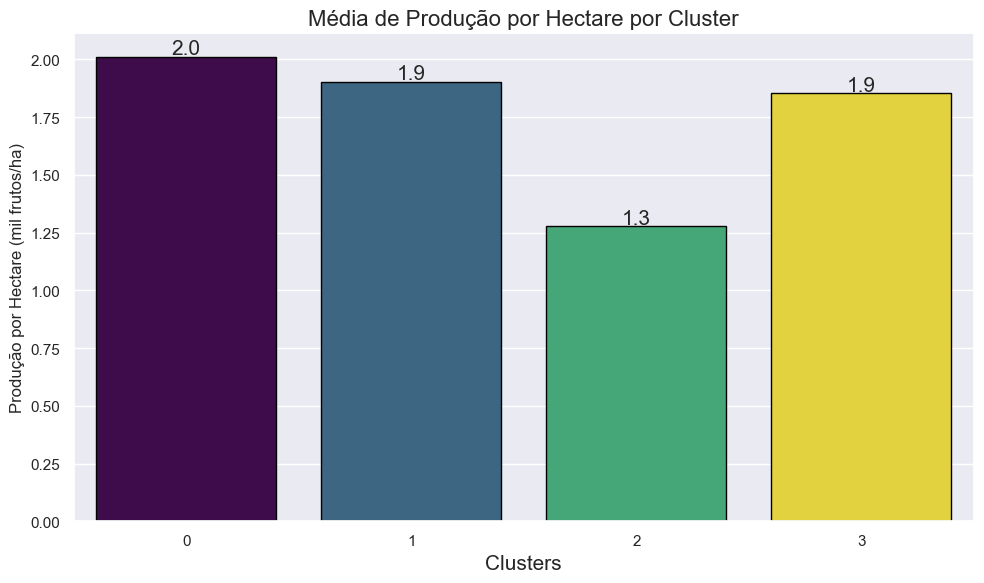

In [96]:
# Gráfico de barras verticais para Média de Produção por Hectare
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    x=df_producao_eficiencia.index, 
    y=df_producao_eficiencia.values, 
    palette='viridis',
    hue=df_producao_eficiencia.index,
    edgecolor='black',
    legend=False
)

# Adicionar título e rótulos
ax.set_title('Média de Produção por Hectare por Cluster', fontsize=16)
ax.set_xlabel('Clusters', fontsize=15)
ax.set_ylabel('Produção por Hectare (mil frutos/ha)', fontsize=12)

# Adicionar valores nas barras
for i, v in enumerate(df_producao_eficiencia.values):
    ax.text(i, v + 0.01, f"{v:.1f}", ha='center', fontsize=15)

plt.tight_layout()
plt.show()


## Análise de Correlação Entre Variáveis

In [19]:
# Analisando correlação entre as variáveis numéricas
correlacao = gdf_clean[['Plantada (ha)', 'Colhida (ha)', 'Produção (mil frutos)', 'Nº de Beneficiários']].corr()

# Exibindo a matriz de correlação
correlacao


,Plantada (ha),Colhida (ha),Produção (mil frutos),Nº de Beneficiários
Plantada (ha),1.000000,0.988708,0.986023,0.904132
Colhida (ha),0.988708,1.000000,0.995178,0.846489
Produção (mil frutos),0.986023,0.995178,1.000000,0.847596
Nº de Beneficiários,0.904132,0.846489,0.847596,1.000000


## Comparação de Beneficiários Entre os Clusters

In [20]:
# Número médio de beneficiários por cluster
beneficiarios_por_cluster = gdf_clean.groupby('Cluster')['Nº de Beneficiários'].mean()

# Exibindo o número médio de beneficiários
beneficiarios_por_cluster


Cluster
0    33.863636
1    10.125000
2    23.000000
3     8.272727
Name: Nº de Beneficiários, dtype: float64

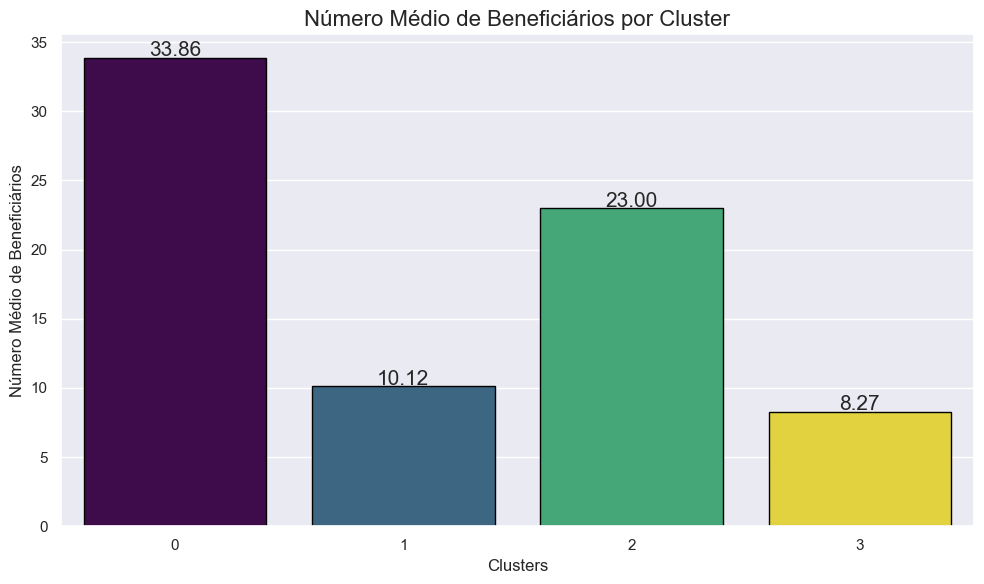

In [ ]:
# Gráfico de barras verticais para Número Médio de Beneficiários ATER por Cluster
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    x=beneficiarios_por_cluster.index, 
    y=beneficiarios_por_cluster.values, 
    palette='viridis', 
    hue=beneficiarios_por_cluster.index,
    edgecolor='black',
    legend=False
)

# Adicionar título e rótulos
ax.set_title('Número Médio de Beneficiários por Cluster', fontsize=16)
ax.set_xlabel('Clusters', fontsize=12)
ax.set_ylabel('Número Médio de Beneficiários', fontsize=12)

# Adicionar valores nas barras
for i, v in enumerate(beneficiarios_por_cluster.values):
    ax.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=15)

plt.tight_layout()
plt.show()


## Tabela com Unidade local por Cluster

In [21]:
# Agrupar as unidades locais por cluster e reclassificar o índice
tabela_clusters = gdf_clean[['Unidade local', 'Cluster']].sort_values(by='Cluster').reset_index(drop=True)

# Exibindo a tabela com as Unidades Locais por Cluster e índice reclassificado
tabela_clusters


,Unidade local,Cluster
0,Parintins,0
1,Autazes,0
2,Iranduba,0
3,Urucará,0
4,Manacapuru,0
5,Manaquiri,0
6,Manaus,0
7,Novo Airão,0
8,Rio Preto da Eva,0
9,Borba,0


In [22]:
# Salvando a tabela como um arquivo Excel
#tabela_clusters.to_excel("unidades_locais_por_cluster.xlsx", index=False)
#print("Salvo!")
